#Detecting Pneumonia in X-Ray Images#

The reason why we find this problem particularly useful is more than 1 million adults are hospitalized with pneumonia and around 50,000 die from the disease every year in the US alone. Chest X-rays are currently the best available method for diagnosing pneumonia , playing a crucial role in clinical care and epidemiological studies . However, detecting pneumonia in chest X-rays is a challenging task that relies on the availability of expert radiologists(as reported by WHO).


In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import seaborn
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import cv2
from skimage.transform import resize
keras.backend.backend()

Using TensorFlow backend.


'tensorflow'

#Load the data#

In [2]:
## load data of converted images from NPZ
X_train = np.load("X_train-pneunonia-grayscale-(5216, 768, 768, 3).npz")['arr_0']
Y_train = np.load("Y_train-pneunonia-grayscale-(5216, 768, 768, 3).npz")['arr_0']
X_val = np.load("X_val-pneunonia-grayscale-(16, 768, 768, 3).npz")['arr_0']
Y_val = np.load("Y_val-pneunonia-grayscale-(16, 768, 768, 3).npz")['arr_0']
X_test = np.load("X_test-pneunonia-grayscale-(624, 768, 768, 3).npz")['arr_0']
Y_test = np.load("Y_test-pneunonia-grayscale-(624, 768, 768, 3).npz")['arr_0']


In [3]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5216, 768, 768, 3)
(5216,)
(624, 768, 768, 3)
(624,)


#show some images between normal vs pneumonia#

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
X = np.concatenate((X_train, np.concatenate((X_test, X_val), axis=0)), axis=0)
Y = np.concatenate((Y_train, np.concatenate((Y_test, Y_val), axis=0)), axis=0)

print(X.shape)
print(Y.shape)


(5216, 768, 768, 3)
(5216,)
(624, 768, 768, 3)
(624,)
(5856, 768, 768, 3)
(5856,)


In [6]:
X_train = None
X_test = None
Y_hot = to_categorical(Y, num_classes = 2)
print(X.shape)
print(Y_hot.shape)
print(Y.shape)

(5856, 768, 768, 3)
(5856, 2)
(5856,)


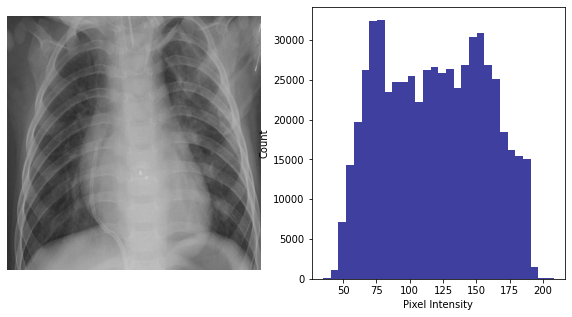

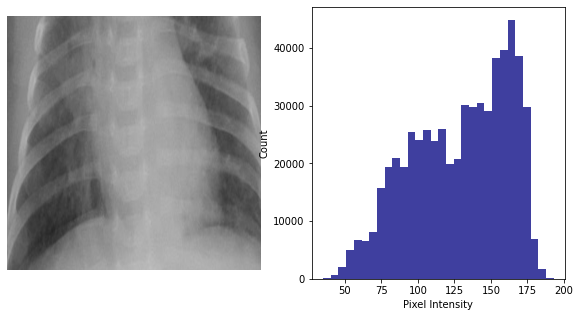

In [7]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    
plotHistogram(X[12])
plotHistogram(X[44])

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


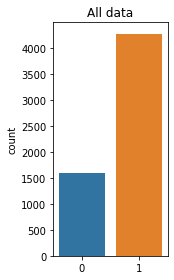

In [8]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
plt.subplot(1,3,1)
seaborn.countplot(np.argmax(Y_hot, axis=1)).set_title('All data')

plt.tight_layout()
print(dict_characters)

**Explain the need of imbalanced ...**

1769472
(5856, 1769472)
{0: 'No Pneumonia', 1: 'Yes Pneumonia'}
{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


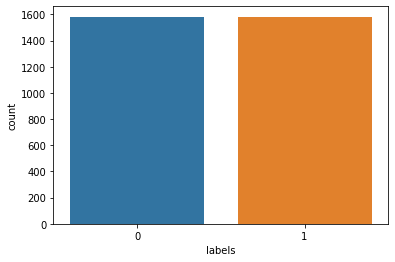

In [9]:
# Deal with imbalanced class sizes
# Make Data 1D for compatability upsampling methods
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
X_ = X.shape[1]*X.shape[2]*X.shape[3]
print(X_)
X_Flat = X.reshape(X.shape[0], X_)
print(X_Flat.shape)

src_size  = 768
ros = RandomUnderSampler(sampling_strategy='auto')
X_ros, Y_ros = ros.fit_sample(X_Flat, Y)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_ros_hot = to_categorical(Y_ros, num_classes = 2)
# Make Data 2D again
height, width, channels = src_size,src_size,3
for i in range(len(X_ros)):
    X_ = X_ros.reshape(len(X_ros),height,width,channels)

# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_ros
labRos = dfRos['labels']

# Plot Label Distribution
import seaborn
seaborn.countplot(labRos)
print({0: 'No Pneumonia', 1: 'Yes Pneumonia'})

print(dict_characters)


**We will try to do Transfer learning w/ VGG16 Convolutional Network and Transfer learning w/ InceptionV3 Convolutional Network**



In [10]:
# Helper Functions  Learning Curves and Confusion Matrix
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import itertools
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

#Building the model#
**Explain about vgg16 and inception v3, and since we do not have enough data to train on CNN, so we have to use pretrained model.....**

In [14]:
import sklearn
from sklearn.utils import class_weight
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam,Adagrad
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_tr,X_ts,Y_tr, Y_ts = train_test_split(X_,Y_ros,test_size=0.2,random_state=13)

map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
image_size = 256
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_tr), Y_tr)

weight_path1 = 'keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

weight_path2 = 'keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(image_size, image_size, 3))

pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(image_size, image_size, 3))


#keras.optimizers.Adagrad(learning_rate=0.01)
def training_report(model,history,xtest,ytest,labels):
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    pprint(score)
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()

def pretrainedNetwork(image_size,xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer):
    from tensorflow.image import resize as reZ    
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc'])
   
    model.summary()
    # Fit model
    history = model.fit(reZ(xtrain,(image_size,image_size)),ytrain, epochs=numepochs, validation_data=(reZ(xtest,(image_size,image_size)),ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    return model,history

np.max(X_), np.max(X)

(255, 255)

In [15]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_ros), Y_ros)
print("New Class Weights: ",class_weight2)
class_weight2.shape

from sklearn.model_selection import train_test_split


Old Class Weights:  [1.84965256 0.68523286]
New Class Weights:  [1. 1.]


** Running VGG16 Convolutional Network**

In [19]:

optimizer1 = RMSprop(lr=0.001)
model, history = pretrainedNetwork(256,X_tr, Y_tr, X_ts, Y_ts, pretrained_model_1,weight_path2,class_weight2,2,8,optimizer1)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [21]:
from pprint import pprint

score = model.evaluate(X_ts,Y_ts, verbose=1)
#training_report(model, history, X_ts, Y_ts,map_characters1)

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1029 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1020 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:952 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2292 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2651 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1013 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:979 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:937 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:725 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:894 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:896 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 32768 but received input with shape [None, 294912]


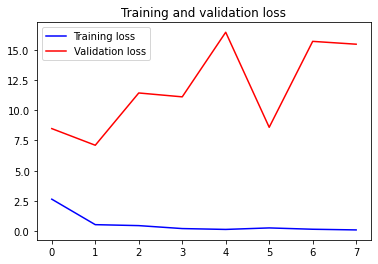

In [43]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochZ = range(8)
plt.figure()
plt.plot(epochZ, loss, 'b', label='Training loss')
plt.plot(epochZ, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Running Transfer learning w/ InceptionV3 Convolutional Network model**

In [44]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-pretrainedNetwork2.hdf5"
weights_improvement = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [EarlyStopping(monitor='val_acc', patience=8, verbose=1),weights_improvement]
    
optimizer1 = RMSprop(lr=0.0005)
model2, history2 = pretrainedNetwork(256,X_tr, Y_tr, X_ts, Y_ts,pretrained_model_2,weight_path2,class_weight2,2,64,optimizer1)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

KeyboardInterrupt: 

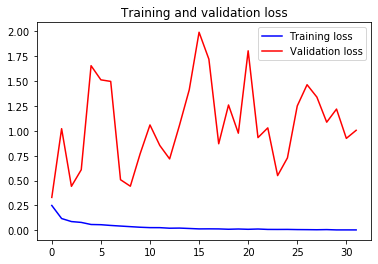

In [35]:
training_report(model2, history2, X_testRosReshaped, Y_testRosHot,map_characters1)
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(64)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Training on GPU

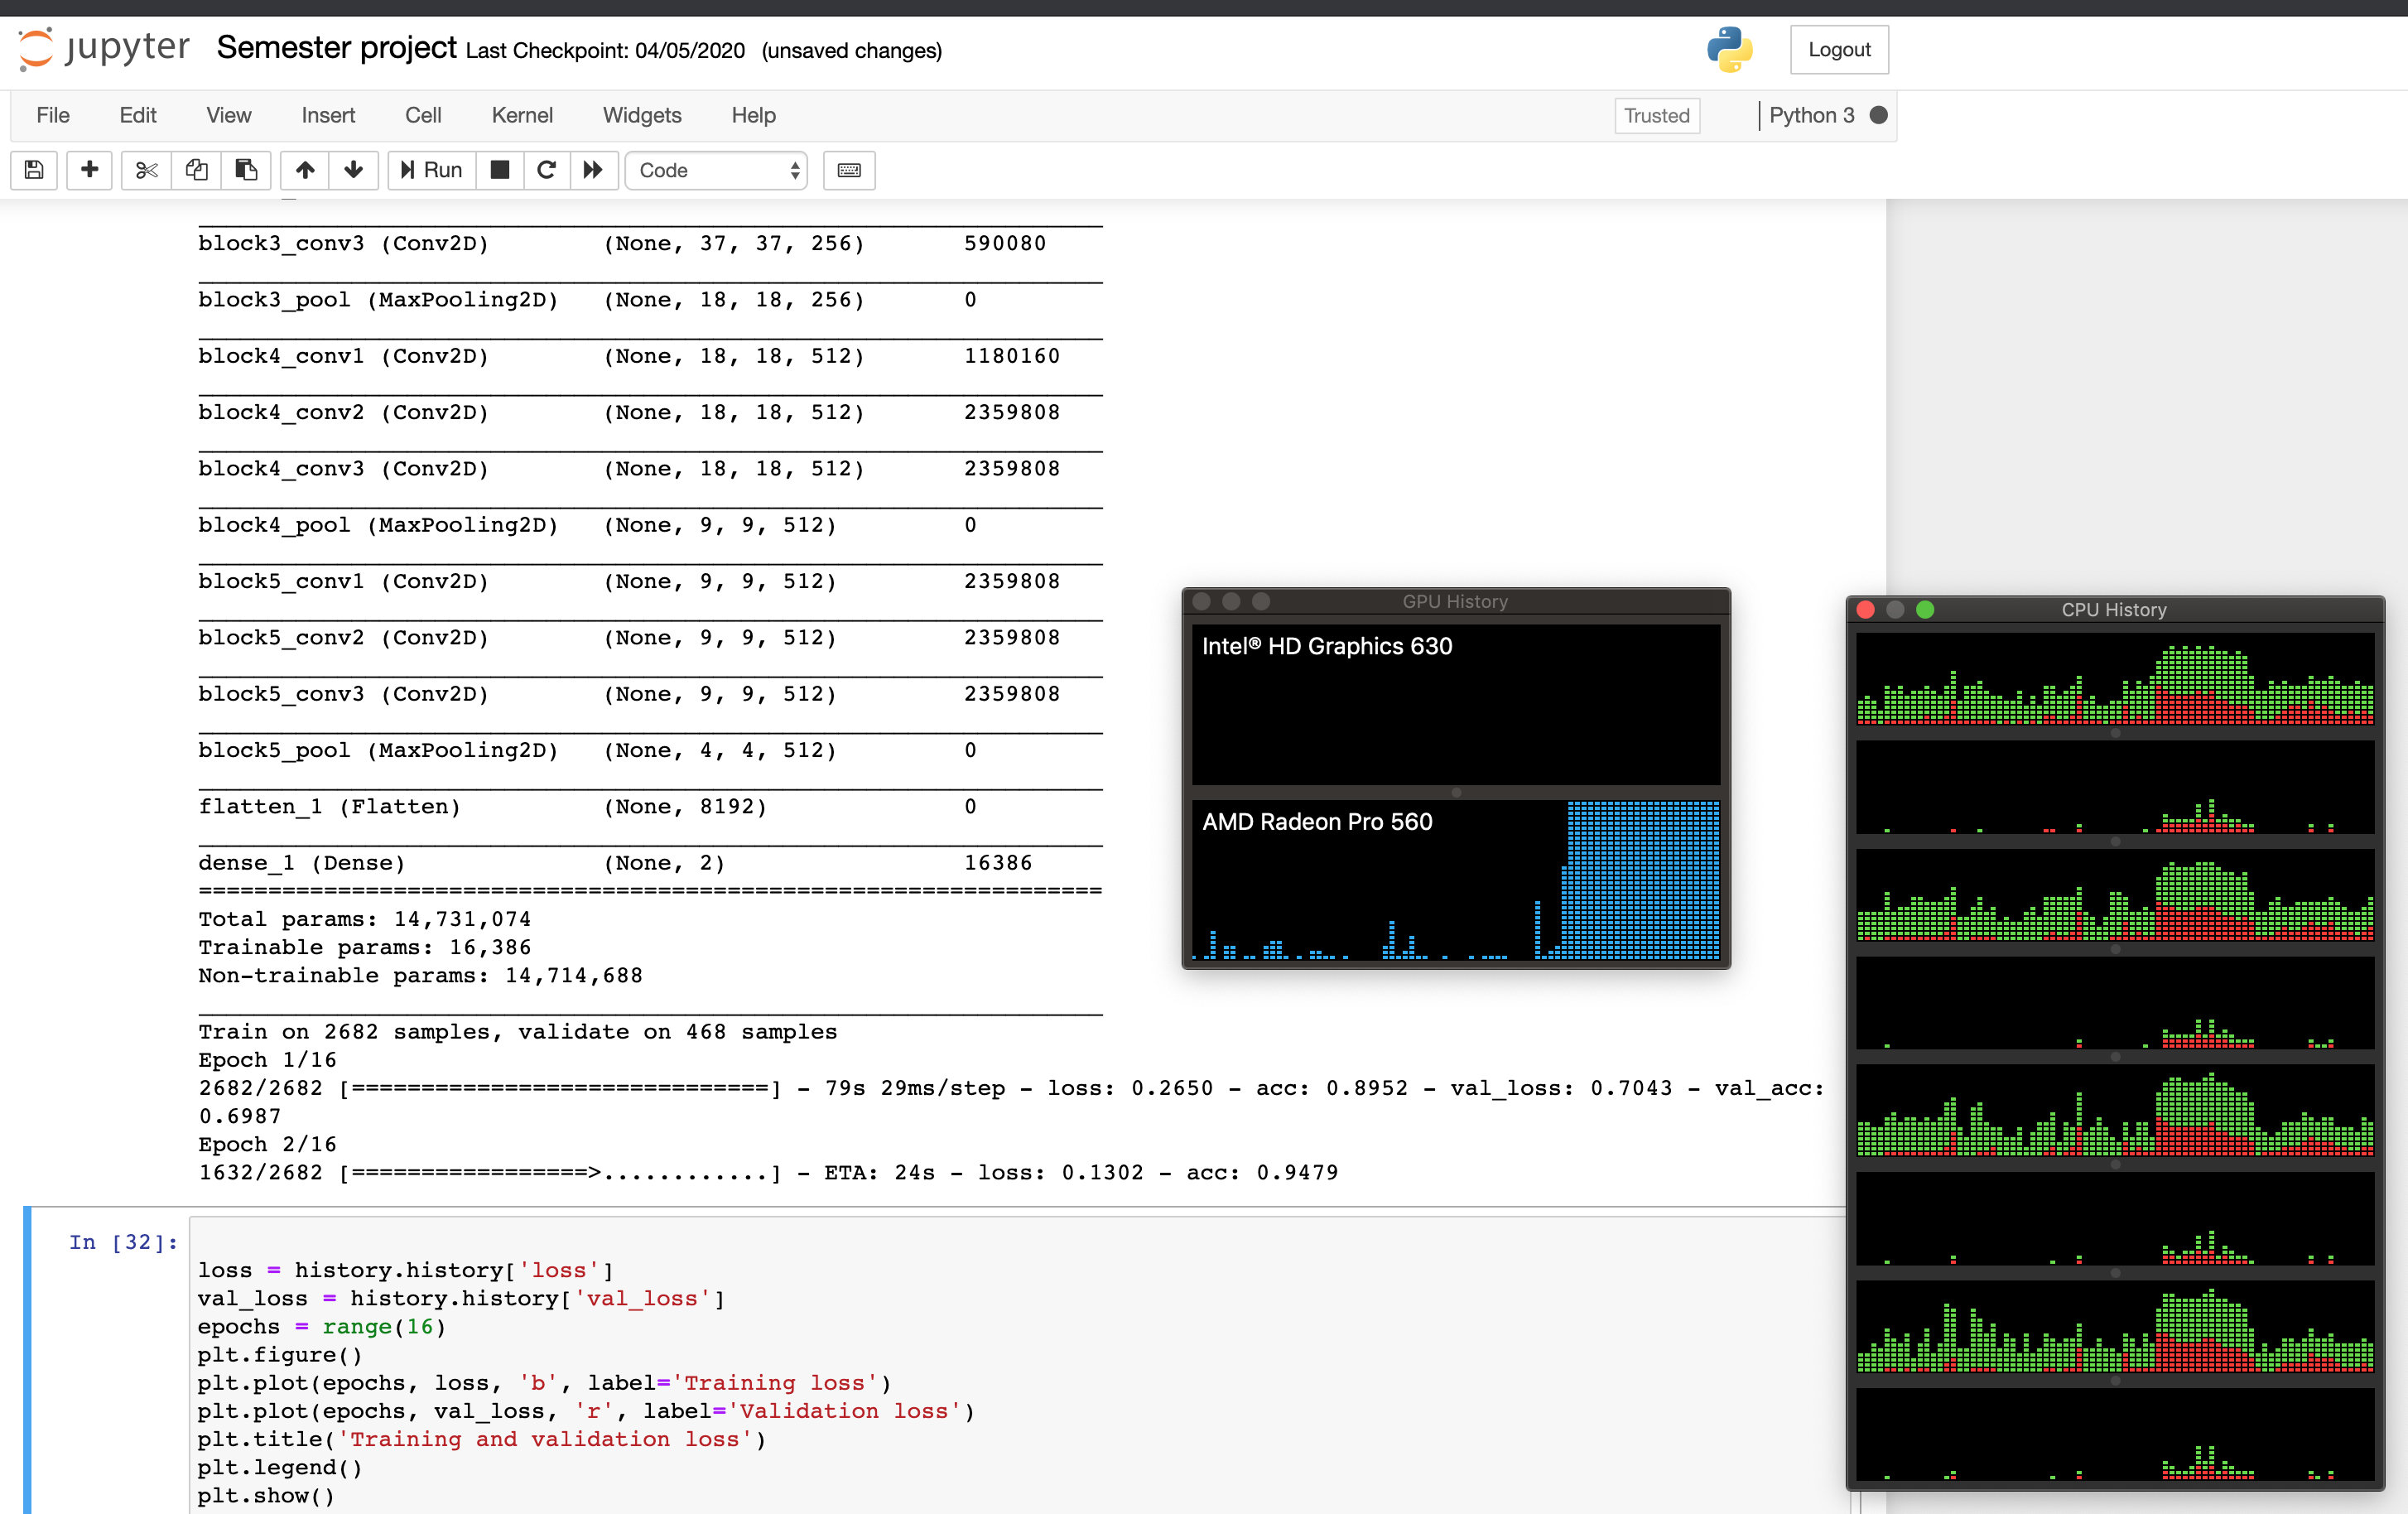

#Conclusion#

The result of VGG16 Convolutional Network gives ...

The result of  InceptionV3 Convolutional Network gives.....

